In [28]:
# Import Libraries
import json

import pandas as pd
import requests
from bs4 import BeautifulSoup as bs

In [29]:
# Send Get request data
WIKI_URL = "https://en.wikipedia.org/w/api.php?formatversion=2&action=parse&page=List_of_most_visited_museums&prop=text&format=json"
response = requests.get(url=WIKI_URL)
wiki_data = json.loads(response.text)
wiki_text = wiki_data["parse"]["text"]



In [30]:
# Parse text
soup = bs(wiki_text, "lxml")
table = soup.find('table')
list_of_rows = []

for row in table.findAll('tr'):  # find row
    list_of_cells = []
    for cell in row.findAll('td'):  # each cell
        # if country in it get country
        if cell.find('a') and cell.find('a').get('title'):
            if cell.find('a').get('class') and 'new' in cell.find('a').get('class'):
                text = cell.text  # A special case
                list_of_cells.append(text.replace(r'\xa0[zh', '').strip())
                continue
            text = cell.find('a').get('title')  # get country
            if cell.find('span'):
                city = cell.text
                list_of_cells.append(city.strip())
        else:  # else get text only
            text = cell.text
        list_of_cells.append(text.strip())
    if list_of_cells:
        list_of_rows.append(list_of_cells)



In [31]:
# Convert into dataframe
df = pd.DataFrame(list_of_rows, columns=['Museum_Name',
                                         'City',
                                         'Country',
                                         'Number_Of_Visitors',
                                         'Year_Reported'])
df['Number_Of_Visitors'] = df['Number_Of_Visitors'].map(lambda num: int(str(num).replace(',', '')))
df['Year_Reported'] = df['Year_Reported'].map(lambda num: int(str(num)[:4]))

In [32]:
# Import database
from db import Database, City

In [33]:
# Create function to get city population
CITY_DATABASE_URI = 'sqlite:///city_info.sqlite'  # db path

city_db = Database(db_uri=CITY_DATABASE_URI)

def get_city_population(city: str, country: str):
    population_results = city_db.session.query(City).filter(City.city == city).first()
    if population_results:
        return population_results.population
    else:
        return None

In [34]:
# Get population into dataframe
city_population_lst = []
for iid, row in df.iterrows():
    city_population = get_city_population(row['City'], row['Country'])
    city_population_lst.append(int(city_population) if city_population else None)



In [35]:
# Save in db
MUSEUM_DATABASE_URI = 'sqlite:///museum.sqlite'  # db path

df['Population_Of_City'] = city_population_lst
db = Database(db_uri=MUSEUM_DATABASE_URI)
db.create_tables()
df.to_sql('museum', index=False, con=db.engine, if_exists='replace')

In [36]:
#访问人数
visited_people = df['Number_Of_Visitors']
#当地人口
population = df['Population_Of_City']

In [37]:
X, y = visited_people.to_numpy(), population.to_numpy()
X, y = X.reshape(-1,1), y.reshape(-1,1)
# Split the data into training/testing sets
X_train, X_test = X[:-20], X[-20:]
# Split the targets into training/testing sets
y_train, y_test = y[:-20], y[-20:]

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
    % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))


Coefficients: 
 [[-0.9207475]]
Mean squared error: 87121314432263.14
Coefficient of determination: -0.29


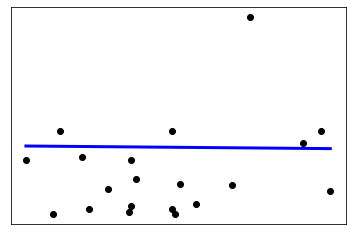

In [39]:
# Plot outputs
import matplotlib.pyplot as plt

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()


